In [60]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import statsmodels.api as sm
from itertools import product

IMPORT DATA SET

In [21]:
# 1.1 Cargar el conjunto de datos desde la URL
url = 'https://raw.githubusercontent.com/d2cml-ai/CausalAI-Course/main/data/wage2015_subsample_inference.csv'
df = pd.read_csv(url)
print(df.head())

   rownames       wage     lwage  sex  shs  hsg  scl  clg   ad   mw  ...   we  \
0        10   9.615385  2.263364  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
1        12  48.076923  3.872802  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
2        15  11.057692  2.403126  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0   
3        18  13.942308  2.634928  1.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0   
4        19  28.846154  3.361977  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   

    ne  exp1  exp2    exp3     exp4     occ  occ2     ind  ind2  
0  1.0   7.0  0.49   0.343   0.2401  3600.0    11  8370.0    18  
1  1.0  31.0  9.61  29.791  92.3521  3050.0    10  5070.0     9  
2  1.0  18.0  3.24   5.832  10.4976  6260.0    19   770.0     4  
3  1.0  25.0  6.25  15.625  39.0625   420.0     1  6990.0    12  
4  1.0  22.0  4.84  10.648  23.4256  2015.0     6  9470.0    22  

[5 rows x 21 columns]


In [22]:
# 1.2.1 Generar el array para la variable de resultado Y y normalizarlo
# Seleccionar la variable dependiente 'lwage' y normalizarla
lwage = df['lwage'].values  # Extraer la columna como array
Y = (lwage - np.mean(lwage)) / np.std(lwage)  # Normalización: (X - media) / desviación estándar
print(Y[:5])


[-1.24037498  1.5815695  -0.99532021 -0.58888559  0.6859018 ]


In [28]:
# Verificar si las columnas 'occ2' e 'ind2' están en el DataFrame
if 'occ2' in df.columns and 'ind2' in df.columns:
    # Crear variables dummy para las categorías 'occ2' e 'ind2'
    df = pd.get_dummies(df, columns=['occ2', 'ind2'], drop_first=True)
else:
    print("Las columnas 'occ2' o 'ind2' no están presentes en el DataFrame.")
    print(f"Columnas actuales del DataFrame: {df.columns}")

# Seleccionar las variables predictoras
variables = [
    'exp1', 'exp2', 'exp3', 'exp4', 'hsg', 'scl', 'clg', 'ad', 'so', 'we', 'ne'
]

# Añadir las variables dummy generadas de 'occ2' e 'ind2' si existen
if 'occ2' in df.columns or 'ind2' in df.columns:
    variables += [col for col in df.columns if 'occ2_' in col or 'ind2_' in col]
else:
    print("No se generaron variables dummy para 'occ2' o 'ind2'.")

# Ahora puedes continuar con el procesamiento de las variables
print("Variables seleccionadas:", variables)


Las columnas 'occ2' o 'ind2' no están presentes en el DataFrame.
Columnas actuales del DataFrame: Index(['rownames', 'wage', 'lwage', 'sex', 'shs', 'hsg', 'scl', 'clg', 'ad',
       'mw', 'so', 'we', 'ne', 'exp1', 'exp2', 'exp3', 'exp4', 'occ', 'ind',
       'occ2_2', 'occ2_3', 'occ2_4', 'occ2_5', 'occ2_6', 'occ2_7', 'occ2_8',
       'occ2_9', 'occ2_10', 'occ2_11', 'occ2_12', 'occ2_13', 'occ2_14',
       'occ2_15', 'occ2_16', 'occ2_17', 'occ2_18', 'occ2_19', 'occ2_20',
       'occ2_21', 'occ2_22', 'ind2_3', 'ind2_4', 'ind2_5', 'ind2_6', 'ind2_7',
       'ind2_8', 'ind2_9', 'ind2_10', 'ind2_11', 'ind2_12', 'ind2_13',
       'ind2_14', 'ind2_15', 'ind2_16', 'ind2_17', 'ind2_18', 'ind2_19',
       'ind2_20', 'ind2_21', 'ind2_22'],
      dtype='object')
No se generaron variables dummy para 'occ2' o 'ind2'.
Variables seleccionadas: ['exp1', 'exp2', 'exp3', 'exp4', 'hsg', 'scl', 'clg', 'ad', 'so', 'we', 'ne']


In [29]:
# 1.2.3 Crear un DataFrame para almacenar solo las interacciones
interactions = pd.DataFrame()

# Añadir la variable "sex" del DataFrame original
interactions['sex'] = df['sex']

# Generar interacciones de dos vías entre las variables en `variables`
for i in range(len(variables)):
    for j in range(i + 1, len(variables)):
        var1 = variables[i]
        var2 = variables[j]
        interaction_col = f"{var1}_x_{var2}"
        interactions[interaction_col] = df[var1] * df[var2]

# Mostrar las primeras filas del DataFrame de interacciones
print(interactions.head())

   sex  exp1_x_exp2  exp1_x_exp3  exp1_x_exp4  exp1_x_hsg  exp1_x_scl  \
0  1.0         3.43        2.401       1.6807         0.0         0.0   
1  0.0       297.91      923.521    2862.9151         0.0         0.0   
2  0.0        58.32      104.976     188.9568        18.0         0.0   
3  1.0       156.25      390.625     976.5625         0.0         0.0   
4  1.0       106.48      234.256     515.3632         0.0         0.0   

   exp1_x_clg  exp1_x_ad  exp1_x_so  exp1_x_we  ...  clg_x_ad  clg_x_so  \
0         7.0        0.0        0.0        0.0  ...       0.0       0.0   
1        31.0        0.0        0.0        0.0  ...       0.0       0.0   
2         0.0        0.0        0.0        0.0  ...       0.0       0.0   
3         0.0       25.0        0.0        0.0  ...       0.0       0.0   
4        22.0        0.0        0.0        0.0  ...       0.0       0.0   

   clg_x_we  clg_x_ne  ad_x_so  ad_x_we  ad_x_ne  so_x_we  so_x_ne  we_x_ne  
0       0.0       1.0      0.0  

In [30]:
# 1.2.4 Generar el array para las features X y normalizarlo
# Seleccionar todas las columnas excepto 'sex'
X = interactions.drop(columns=['sex']).values

# Normalizar las columnas de X
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Crear un nuevo DataFrame con las variables normalizadas
df_normalized = pd.DataFrame(X_normalized, columns=interactions.columns.drop('sex'))

# Añadir la columna 'sex' de vuelta al DataFrame
df_normalized.insert(0, 'sex', interactions['sex'].values)

# Mostrar las primeras filas del DataFrame normalizado
print(df_normalized.head())

   sex  exp1_x_exp2  exp1_x_exp3  exp1_x_exp4  exp1_x_hsg  exp1_x_scl  \
0  1.0    -0.544803    -0.464791    -0.402753   -0.464679    -0.47979   
1  0.0     1.487838     1.256124     1.009824   -0.464679    -0.47979   
2  0.0    -0.165926    -0.273151    -0.310296    1.541550    -0.47979   
3  1.0     0.510033     0.260522     0.078541   -0.464679    -0.47979   
4  1.0     0.166497    -0.031620    -0.149151   -0.464679    -0.47979   

   exp1_x_clg  exp1_x_ad  exp1_x_so  exp1_x_we  ...  clg_x_ad  clg_x_so  \
0    0.460812  -0.282080  -0.469972  -0.399934  ...       0.0 -0.318014   
1    3.606012  -0.282080  -0.469972  -0.399934  ...       0.0 -0.318014   
2   -0.456537  -0.282080  -0.469972  -0.399934  ...       0.0 -0.318014   
3   -0.456537   4.121672  -0.469972  -0.399934  ...       0.0 -0.318014   
4    2.426562  -0.282080  -0.469972  -0.399934  ...       0.0 -0.318014   

   clg_x_we  clg_x_ne   ad_x_so   ad_x_we   ad_x_ne  so_x_we  so_x_ne  we_x_ne  
0 -0.272917  3.321552 -0.2254

In [31]:
# 1.3 Dividir entre muestras de entrenamiento y prueba (10% para prueba)
# Semilla para reproducibilidad
np.random.seed(611)

# Concatenar la variable objetivo Y normalizada con las features
model = pd.concat([pd.DataFrame({'wage_norm': Y}), df_normalized], axis=1)
print(model.head())

# Dividir los datos en entrenamiento y prueba (10% de los datos para prueba)
train_size = 0.9  # 90% para entrenamiento, 10% para prueba
X_train, X_test, Y_train, Y_test = train_test_split(
    model.drop(columns=['wage_norm']),  # Features (sin wage_norm)
    model['wage_norm'],                 # Target (wage_norm)
    train_size=train_size,
    random_state=611
)

# Mostrar las dimensiones de los conjuntos
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de Y_train: {Y_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de Y_test: {Y_test.shape}")


   wage_norm  sex  exp1_x_exp2  exp1_x_exp3  exp1_x_exp4  exp1_x_hsg  \
0  -1.240375  1.0    -0.544803    -0.464791    -0.402753   -0.464679   
1   1.581570  0.0     1.487838     1.256124     1.009824   -0.464679   
2  -0.995320  0.0    -0.165926    -0.273151    -0.310296    1.541550   
3  -0.588886  1.0     0.510033     0.260522     0.078541   -0.464679   
4   0.685902  1.0     0.166497    -0.031620    -0.149151   -0.464679   

   exp1_x_scl  exp1_x_clg  exp1_x_ad  exp1_x_so  ...  clg_x_ad  clg_x_so  \
0    -0.47979    0.460812  -0.282080  -0.469972  ...       0.0 -0.318014   
1    -0.47979    3.606012  -0.282080  -0.469972  ...       0.0 -0.318014   
2    -0.47979   -0.456537  -0.282080  -0.469972  ...       0.0 -0.318014   
3    -0.47979   -0.456537   4.121672  -0.469972  ...       0.0 -0.318014   
4    -0.47979    2.426562  -0.282080  -0.469972  ...       0.0 -0.318014   

   clg_x_we  clg_x_ne   ad_x_so   ad_x_we   ad_x_ne  so_x_we  so_x_ne  we_x_ne  
0 -0.272917  3.321552 -0.2254

# 2. Creating the Lasso Cross-Validation Procedure

In [33]:
# 2.4. Función logarítmicamente espaciada
def log_grid(lower_bound, upper_bound, log_spacing):
    num_points = int(round((np.log(upper_bound) - np.log(lower_bound)) / log_spacing)) + 1
    log_grid = np.linspace(np.log(lower_bound), np.log(upper_bound), num_points)
    return np.exp(log_grid)

# Ejemplo: cuadrícula logarítmica
lower_bound = 0.001  # Límite inferior
upper_bound = 1.0    # Límite superior
log_spacing = 0.1    # Espaciado logarítmico
λ_grid = log_grid(lower_bound, upper_bound, log_spacing)
print(f"Logarithmic Grid (first 5 values): {λ_grid[:5]}")

Logarithmic Grid (first 5 values): [0.001      0.0011053  0.00122168 0.00135031 0.0014925 ]


In [34]:
# 2.5. Función para generar k-pliegues
def generate_k_folds(data, k):
    n = data.shape[0]  # Número de filas
    fold_size = n // k  # Tamaño base de cada pliegue
    remainder = n % k   # Filas adicionales para los primeros pliegues
    
    # Crear una lista de booleanos
    folds = np.zeros((n, k), dtype=bool)
    
    # Crear una permutación aleatoria de los índices
    indices = np.random.permutation(n)
    
    # Dividir los índices en k pliegues
    start_idx = 0
    for i in range(k):
        current_fold_size = fold_size + (1 if i < remainder else 0)
        end_idx = start_idx + current_fold_size
        folds[indices[start_idx:end_idx], i] = True
        start_idx = end_idx
    
    return [folds[:, i] for i in range(k)]

# Ejemplo de uso
data = np.random.rand(515, 1327)  # Datos de ejemplo (filas x columnas)
k = 5  # Número de pliegues
folds = generate_k_folds(data, k)
print(f"K-fold sizes: {[np.sum(f) for f in folds]}")  # Tamaños de los pliegues

K-fold sizes: [103, 103, 103, 103, 103]


In [36]:
# 2.6. Función de validación cruzada para Lasso
def cross_validation_lasso(Y_train, X_train, all_lambdas, k_folds):
    all_mse = np.zeros((len(all_lambdas), len(k_folds)))
    
    for lambda_idx, lambda_val in enumerate(all_lambdas):
        for fold_idx, test_mask in enumerate(k_folds):
            train_indices = np.where(~test_mask)[0]
            test_indices = np.where(test_mask)[0]
            
            X_train_fold, X_test_fold = X_train[train_indices, :], X_train[test_indices, :]
            Y_train_fold, Y_test_fold = Y_train[train_indices], Y_train[test_indices]
            
            # Ajustar el modelo Lasso para el pliegue actual
            lasso = Lasso(alpha=lambda_val)
            lasso.fit(X_train_fold, Y_train_fold)
            
            # Predecir y calcular el MSE
            Y_pred = lasso.predict(X_test_fold)
            mse = mean_squared_error(Y_test_fold, Y_pred)
            all_mse[lambda_idx, fold_idx] = mse
    
    # Calcular el MSE promedio para cada lambda
    avg_mse = np.mean(all_mse, axis=1)
    
    # Encontrar el lambda óptimo (el que minimiza el MSE promedio)
    optimal_lambda_idx = np.argmin(avg_mse)
    optimal_lambda = all_lambdas[optimal_lambda_idx]
    
    # Ajustar el modelo final con el lambda óptimo
    lasso_final = Lasso(alpha=optimal_lambda)
    lasso_final.fit(X_train, Y_train)
    
    optimal_coef = lasso_final.coef_
    
    return {
        'optimal_lambda': optimal_lambda,
        'optimal_coef': optimal_coef,
        'all_lambdas': all_lambdas,
        'all_mse': avg_mse
    }

# Llamar a la función de validación cruzada con ejemplos de datos
Y_train = np.random.rand(515)
X_train = np.random.rand(515, 1327)
resultados = cross_validation_lasso(Y_train, X_train, λ_grid, folds)

# Imprimir el lambda óptimo y los MSEs promedio
print("Lambda óptimo:", resultados['optimal_lambda'])
print("Coeficientes óptimos (diferentes de cero):", resultados['optimal_coef'])
print("Todos los lambdas:", resultados['all_lambdas'])
print("MSE por cada lambda:", resultados['all_mse'])

Lambda óptimo: 0.01649648074098021
Coeficientes óptimos (diferentes de cero): [ 0. -0.  0. ...  0. -0.  0.]
Todos los lambdas: [0.001      0.0011053  0.00122168 0.00135031 0.0014925  0.00164965
 0.00182335 0.00201534 0.00222754 0.00246209 0.00272134 0.00300788
 0.0033246  0.00367466 0.00406159 0.00448925 0.00496195 0.00548442
 0.0060619  0.00670019 0.00740568 0.00818547 0.00904736 0.01
 0.01105295 0.01221677 0.01350314 0.01492496 0.01649648 0.01823348
 0.02015338 0.02227543 0.02462092 0.02721339 0.03007883 0.03324598
 0.03674662 0.04061586 0.04489251 0.04961948 0.05484417 0.06061899
 0.06700188 0.07405685 0.08185467 0.09047357 0.1        0.11052951
 0.12216773 0.1350314  0.14924955 0.16496481 0.1823348  0.20153377
 0.2227543  0.24620924 0.27213388 0.30078825 0.33245979 0.36746619
 0.4061586  0.44892513 0.49619476 0.54844166 0.6061899  0.67001875
 0.74056847 0.81854673 0.90473572 1.        ]
MSE por cada lambda: [0.13098739 0.12882901 0.12661331 0.124295   0.1218603  0.11933347
 0.11712

In [37]:

# 2.7. Función para predecir con el modelo óptimo
def predict_lasso(optimal_model, X):
    optimal_coef = optimal_model['optimal_coef']
    
    # Asegurarse de que los coeficientes están en la forma correcta
    if len(optimal_coef.shape) == 1:
        optimal_coef = optimal_coef.reshape(-1, 1)
    
    # Si el número de columnas de X es uno menos que el número de coeficientes, agregar una columna de unos
    if optimal_coef.shape[0] == X.shape[1] + 1:
        X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # Calcular las predicciones
    Y_pred = np.dot(X, optimal_coef)
    
    return Y_pred

# Predicciones usando el modelo óptimo
X_test = np.random.rand(100, 1327)  # Datos de prueba
Y_pred = predict_lasso(resultados, X_test)
print("Valores predichos finales:", Y_pred)

Valores predichos finales: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


# 3. Applying the Lasso Cross-Validation Procedure

In [48]:
# 3.8. Ajustar un modelo OLS simple con la muestra de entrenamiento
X_train_matrix = sm.add_constant(X_train)  # Añadir una constante para el intercepto
modelo_ols = sm.OLS(Y_train, X_train_matrix).fit()

# Imprimir los resultados del OLS
print("Resumen del modelo OLS:")
print(modelo_ols.summary())


Resumen del modelo OLS:


c:\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
c:\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 21 Sep 2024   Prob (F-statistic):                nan
Time:                        21:49:46   Log-Likelihood:                 16914.
No. Observations:                 515   AIC:                        -3.280e+04
Df Residuals:                       0   BIC:                        -3.061e+04
Df Model:                         514                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025        inf          0        n

In [49]:
# 3.9. Encontrar el lambda óptimo y sus coeficientes con la función programada anteriormente
optimal_lambda = resultados['optimal_lambda']
optimal_coef = resultados['optimal_coef']
print(f"Lambda óptimo (cross-validation): {optimal_lambda}")
print(f"Coeficientes del modelo con lambda óptimo: {optimal_coef}")


Lambda óptimo (cross-validation): 0.01649648074098021
Coeficientes del modelo con lambda óptimo: [ 0. -0.  0. ...  0. -0.  0.]


In [52]:
# 3.10. Ajustar un modelo Lasso con el lambda óptimo usando scikit-learn
lasso_teorico = Lasso(alpha=optimal_lambda)
lasso_teorico.fit(X_train, Y_train)

# Imprimir los coeficientes
print("Coeficientes del modelo Lasso con lambda teórico (scikit-learn):")
print(lasso_teorico.coef_)

Coeficientes del modelo Lasso con lambda teórico (scikit-learn):
[ 0. -0.  0. ...  0. -0.  0.]


In [57]:
# Asegurarse de que la división entre entrenamiento y prueba es consistente
# Por ejemplo, utilizando train_test_split

# X debería ser el conjunto completo de predictores, e Y el conjunto completo de la variable objetivo
# Ejemplo de división
X = np.random.rand(515, 1327)  # Conjunto de predictores
Y = np.random.rand(515)  # Conjunto de la variable objetivo

# Dividir en entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de Y_train: {Y_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de Y_test: {Y_test.shape}")

# 3.8 Ajustar un modelo OLS con la muestra de entrenamiento
X_train_matrix = sm.add_constant(X_train)  # Añadir una constante para el intercepto
modelo_ols = sm.OLS(Y_train, X_train_matrix).fit()

# Hacer predicciones con el conjunto de prueba
X_test_matrix = sm.add_constant(X_test)  # Añadir constante al conjunto de prueba
Y_pred_ols = modelo_ols.predict(X_test_matrix)

# Verificar que los tamaños coinciden antes de calcular MSE y R²
print(f"Tamaño de Y_test: {Y_test.shape}")
print(f"Tamaño de Y_pred_ols: {Y_pred_ols.shape}")

if len(Y_test) == len(Y_pred_ols):
    mse_ols = mean_squared_error(Y_test, Y_pred_ols)
    r2_ols = r2_score(Y_test, Y_pred_ols)
    
    print(f"OLS MSE: {mse_ols}")
    print(f"OLS R2: {r2_ols}")
else:
    print("Error: Los tamaños de Y_test y Y_pred_ols no coinciden.")

Tamaño de X_train: (412, 1327)
Tamaño de Y_train: (412,)
Tamaño de X_test: (103, 1327)
Tamaño de Y_test: (103,)
Tamaño de Y_test: (103,)
Tamaño de Y_pred_ols: (103,)
OLS MSE: 0.11661987194761003
OLS R2: -0.5899670278618552


In [58]:
# Verificar las dimensiones antes de predecir
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de Y_test: {Y_test.shape}")

# Asegurarse de que se está utilizando el conjunto de prueba correcto
X_test_matrix = sm.add_constant(X_test)  # Añadir constante al conjunto de prueba
Y_pred_ols = modelo_ols.predict(X_test_matrix)

# Verificar el tamaño de las predicciones
print(f"Tamaño de Y_pred_ols: {Y_pred_ols.shape}")

# Asegurarse de que las longitudes de Y_test y Y_pred_ols coinciden antes de calcular MSE
if len(Y_test) == len(Y_pred_ols):
    mse_ols = mean_squared_error(Y_test, Y_pred_ols)
    r2_ols = r2_score(Y_test, Y_pred_ols)
    
    print(f"OLS MSE: {mse_ols}")
    print(f"OLS R2: {r2_ols}")
else:
    print("Error: Los tamaños de Y_test y Y_pred_ols no coinciden.")

Tamaño de X_test: (103, 1327)
Tamaño de Y_test: (103,)
Tamaño de Y_pred_ols: (103,)
OLS MSE: 0.11661987194761003
OLS R2: -0.5899670278618552


In [59]:
# 3.11. Reportar el MSE y el R2 para los modelos OLS, Lasso con cross-validation, y Lasso con lambda teórico

# --- Evaluación del modelo OLS ---
X_test_matrix = sm.add_constant(X_test)  # Añadir constante al conjunto de prueba
Y_pred_ols = modelo_ols.predict(X_test_matrix)

mse_ols = mean_squared_error(Y_test, Y_pred_ols)
r2_ols = r2_score(Y_test, Y_pred_ols)

print(f"OLS MSE: {mse_ols}")
print(f"OLS R2: {r2_ols}")

# --- Evaluación del modelo Lasso con cross-validation ---
Y_pred_lasso_cv = predict_lasso(resultados, X_test)  # Usar la función de predicción programada antes

mse_lasso_cv = mean_squared_error(Y_test, Y_pred_lasso_cv)
r2_lasso_cv = r2_score(Y_test, Y_pred_lasso_cv)

print(f"Lasso (cross-validation) MSE: {mse_lasso_cv}")
print(f"Lasso (cross-validation) R2: {r2_lasso_cv}")

# --- Evaluación del modelo Lasso con lambda óptimo (scikit-learn) ---
Y_pred_lasso_teorico = lasso_teorico.predict(X_test)

mse_lasso_teorico = mean_squared_error(Y_test, Y_pred_lasso_teorico)
r2_lasso_teorico = r2_score(Y_test, Y_pred_lasso_teorico)

print(f"Lasso (teórico) MSE: {mse_lasso_teorico}")
print(f"Lasso (teórico) R2: {r2_lasso_teorico}")

# Resumen de resultados
print("\n--- Comparación de Modelos ---")
print(f"OLS MSE: {mse_ols}, R2: {r2_ols}")
print(f"Lasso (cross-validation) MSE: {mse_lasso_cv}, R2: {r2_lasso_cv}")
print(f"Lasso (teórico) MSE: {mse_lasso_teorico}, R2: {r2_lasso_teorico}")

OLS MSE: 0.11661987194761003
OLS R2: -0.5899670278618552
Lasso (cross-validation) MSE: 0.2834899016106721
Lasso (cross-validation) R2: -2.8650325091701268
Lasso (teórico) MSE: 0.07377173647960102
Lasso (teórico) R2: -0.005785949099415211

--- Comparación de Modelos ---
OLS MSE: 0.11661987194761003, R2: -0.5899670278618552
Lasso (cross-validation) MSE: 0.2834899016106721, R2: -2.8650325091701268
Lasso (teórico) MSE: 0.07377173647960102, R2: -0.005785949099415211


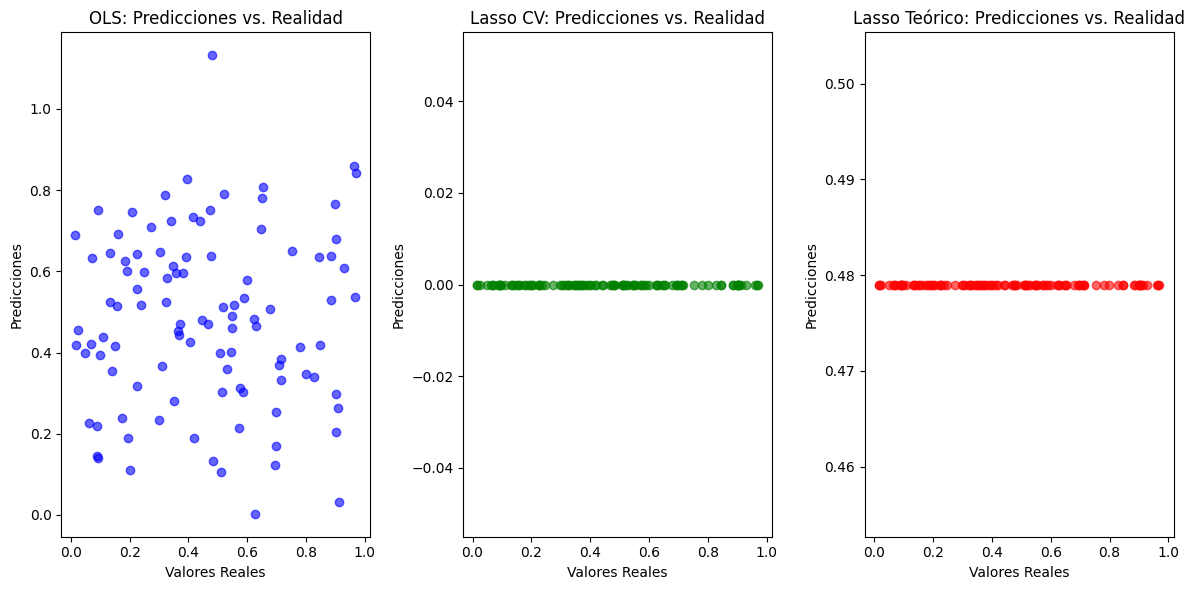

In [61]:
# Comparar las predicciones vs. los valores reales para los tres modelos
plt.figure(figsize=(12, 6))

# OLS
plt.subplot(1, 3, 1)
plt.scatter(Y_test, Y_pred_ols, color='blue', alpha=0.6)
plt.title("OLS: Predicciones vs. Realidad")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")

# Lasso (cross-validation)
plt.subplot(1, 3, 2)
plt.scatter(Y_test, Y_pred_lasso_cv, color='green', alpha=0.6)
plt.title("Lasso CV: Predicciones vs. Realidad")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")

# Lasso (teórico)
plt.subplot(1, 3, 3)
plt.scatter(Y_test, Y_pred_lasso_teorico, color='red', alpha=0.6)
plt.title("Lasso Teórico: Predicciones vs. Realidad")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")

plt.tight_layout()
plt.show()
